<ipython-input-7-97438cfdd1eb>:165: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(risky_ips, rotation=45, ha='right', fontsize=10)



### Results ###

Heavy Hitters (Traditional Approach):
IP: 192.168.1.60, Count: 15
IP: 192.168.1.50, Count: 15

Heavy Hitters (Bloom Filter Approach):
IP: 192.168.1.60, Count: 15
IP: 192.168.1.50, Count: 15

Risky IP Counts:
defaultdict(<class 'int'>, {'192.168.1.60': 15, '192.168.1.188': 1, '192.168.1.194': 2, '192.168.1.51': 1, '192.168.1.27': 1, '192.168.1.114': 1, '192.168.1.191': 1, '192.168.1.88': 1, '192.168.1.50': 15, '192.168.1.232': 1, '192.168.1.121': 1, '192.168.1.36': 1, '192.168.1.98': 1, '192.168.1.105': 1, '192.168.1.6': 1, '192.168.1.151': 1, '192.168.1.41': 1, '192.168.1.52': 1, '192.168.1.69': 1, '192.168.1.118': 1, '192.168.1.161': 1, '192.168.1.231': 1, '192.168.1.32': 1, '192.168.1.165': 1, '192.168.1.132': 1, '192.168.1.108': 1, '192.168.1.228': 1, '192.168.1.107': 1, '192.168.1.55': 1, '192.168.1.247': 1, '192.168.1.162': 1, '192.168.1.177': 1, '192.168.1.57': 1, '192.168.1.19': 1, '192.168.1.38': 2, '192.168.1.255': 1, '192.168.1.90': 1, '192.168.1.99': 1, '19

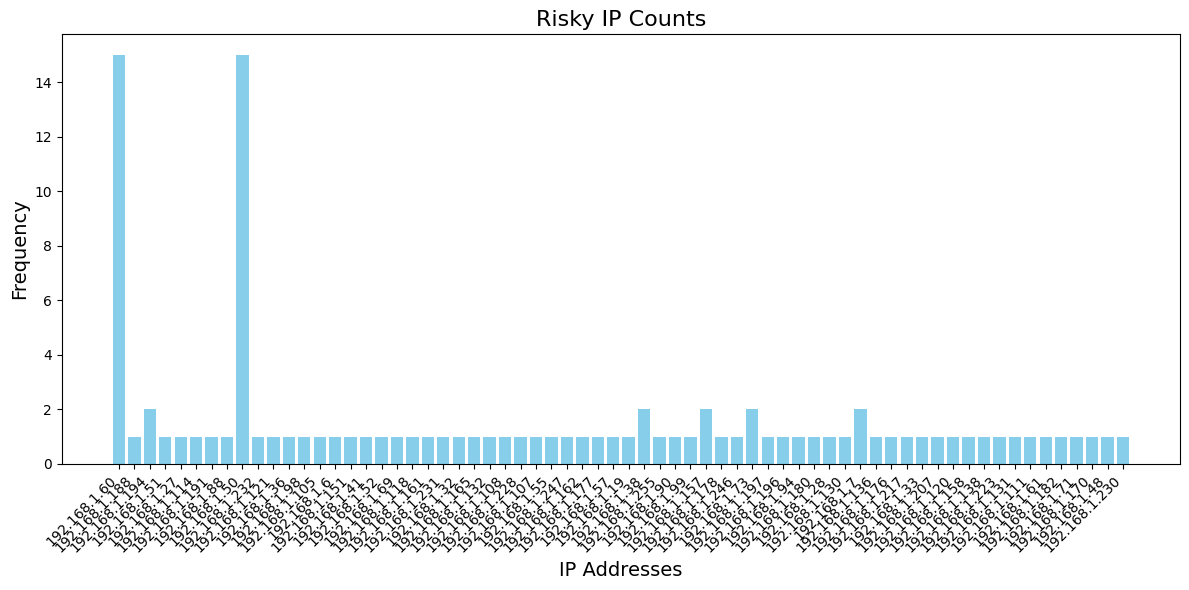

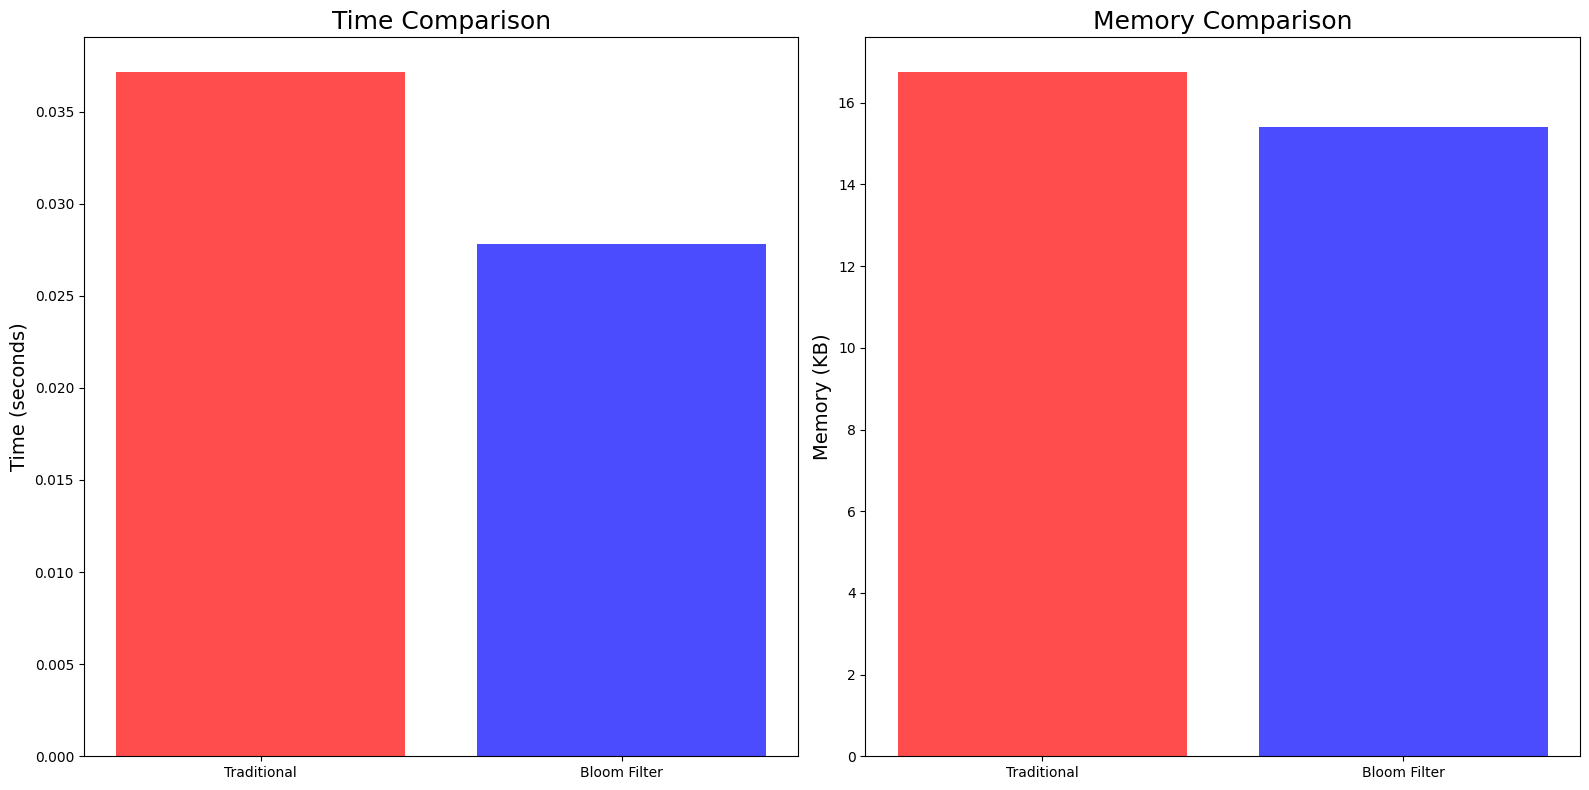

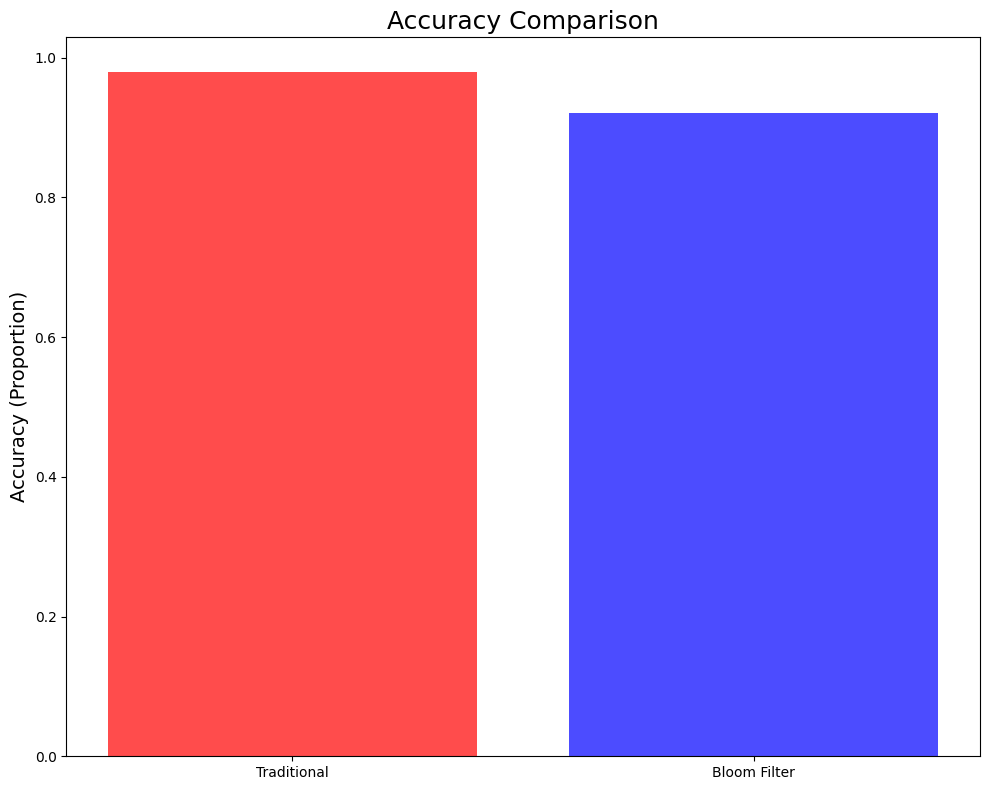

In [7]:
# Required Libraries
!pip install pybloom-live pandas matplotlib

import pandas as pd
import time
import logging
from collections import defaultdict
from pybloom_live import BloomFilter
import pickle
import tracemalloc
import matplotlib.pyplot as plt

# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Parameters
MAX_MONITORED_ELEMENTS = 10  # Number of elements to monitor in Misra-Gries
BLOOM_FILTER_SIZE = 1000  # Capacity of the Bloom Filter
ERROR_RATE = 0.001  # Error rate for Bloom Filter

# File to store the bad bloom filter
BLOOM_FILTER_FILE = "bad_bloom_filter.pkl"

# Load Dataset
try:
    file_path = 'IP_dataset.csv'  # Update with your dataset file path
    data = pd.read_csv(file_path)
    if 'ip_address' not in data.columns:
        raise ValueError("Dataset must contain an 'ip_address' column.")
    logging.info("Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("The file 'IP_dataset.csv' was not found. Please provide the correct file.")
except Exception as e:
    raise ValueError(f"Error loading dataset: {e}")

# Initialize or Load Bad Bloom Filter
try:
    with open(BLOOM_FILTER_FILE, 'rb') as file:
        bad_bloom_filter = pickle.load(file)
        logging.info("Bad Bloom Filter loaded successfully.")
except (FileNotFoundError, EOFError, pickle.UnpicklingError) as e:
    bad_bloom_filter = BloomFilter(capacity=BLOOM_FILTER_SIZE, error_rate=ERROR_RATE)
    logging.warning(f"Bad Bloom Filter reinitialized due to error: {e}")
    bad_bloom_filter.add("192.168.1.250")
    logging.info("Bad Bloom Filter initialized with default values.")

# Initialize Bloom Filter with known safe IPs
KNOWN_IP_ADDRESSES = ["192.168.1.10", "192.168.1.20", "192.168.1.30", "192.168.1.198"]  # Replace with real-world known IPs
bloom_filter = BloomFilter(capacity=BLOOM_FILTER_SIZE, error_rate=ERROR_RATE)
for ip in KNOWN_IP_ADDRESSES:
    bloom_filter.add(ip)

logging.info("Bloom filter initialized with known safe IP addresses.")

# Calculate dynamic frequency threshold
FREQUENCY_THRESHOLD = max(2, len(data) // 10)  # Top 10% as heavy hitters

# Function Definitions
def process_ip_dataset(data):
    start_time = time.time()

    ip_counts = defaultdict(int)
    safe_ips_found = set()

    for index, row in data.iterrows():
        ip_address = row['ip_address']
        if ip_address in bad_bloom_filter:
            continue
        if ip_address in bloom_filter:
            safe_ips_found.add(ip_address)
        else:
            ip_counts[ip_address] += 1

    monitored_elements = {}
    for ip, count in ip_counts.items():
        if ip in monitored_elements:
            monitored_elements[ip] += count
        elif len(monitored_elements) < MAX_MONITORED_ELEMENTS:
            monitored_elements[ip] = count
        else:
            for key in list(monitored_elements.keys()):
                monitored_elements[key] -= 1
                if monitored_elements[key] == 0:
                    del monitored_elements[key]

    monitored_elements = {ip: ip_counts[ip] for ip in monitored_elements.keys()}
    heavy_hitters = {ip: count for ip, count in monitored_elements.items() if count >= FREQUENCY_THRESHOLD}

    end_time = time.time()
    processing_time = end_time - start_time

    return ip_counts, heavy_hitters, safe_ips_found, processing_time


def traditional_approach(data, threshold):
    start_time = time.time()
    ip_counts = defaultdict(int)

    for index, row in data.iterrows():
        ip_address = row['ip_address']
        if ip_address not in KNOWN_IP_ADDRESSES:
            ip_counts[ip_address] += 1

    heavy_hitters = {ip: count for ip, count in ip_counts.items() if count >= threshold}
    end_time = time.time()
    processing_time = end_time - start_time

    return ip_counts, heavy_hitters, processing_time


# Measure Performance and Memory Utilization for Both Approaches
tracemalloc.start()
traditional_ip_counts, traditional_heavy_hitters, traditional_processing_time = traditional_approach(data, FREQUENCY_THRESHOLD)
traditional_memory = tracemalloc.get_traced_memory()
tracemalloc.stop()

tracemalloc.start()
risky_ip_counts, heavy_hitters, safe_ips_found, bloom_processing_time = process_ip_dataset(data)
bloom_memory = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Results (Heavy Hitters Display)
print("\n### Results ###")
print("\nHeavy Hitters (Traditional Approach):")
for ip, count in traditional_heavy_hitters.items():
    print(f"IP: {ip}, Count: {count}")

print("\nHeavy Hitters (Bloom Filter Approach):")
for ip, count in heavy_hitters.items():
    print(f"IP: {ip}, Count: {count}")
print("\nRisky IP Counts:")
print(risky_ip_counts)
print("\nSafe IPs Found (Bloom Filter Approach):", safe_ips_found)
print(f"\nFrequency Threshold: {FREQUENCY_THRESHOLD}")
print(f"\nProcessing Time (Traditional Approach): {traditional_processing_time:.2f} seconds")
print(f"Processing Time (Bloom Filter Approach): {bloom_processing_time:.2f} seconds")

# Update and Save Bad Bloom Filter
for ip in heavy_hitters.keys():
    if ip not in bad_bloom_filter:
        bad_bloom_filter.add(ip)

try:
    with open(BLOOM_FILTER_FILE, 'wb') as file:
        pickle.dump(bad_bloom_filter, file)
except Exception as e:
    logging.error(f"Failed to save the Bad Bloom Filter: {e}")


# Display Bad Bloom Filter Contents
bad_bloom_ips = [ip for ip in heavy_hitters.keys()]
print("\nCurrent Bad Bloom Filter Contents (Forbidden IPs):")
print(bad_bloom_ips)

# Visualization
# Risky IP Counts Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))
risky_ips = list(risky_ip_counts.keys())
risky_counts = list(risky_ip_counts.values())

ax.bar(risky_ips, risky_counts, color='skyblue')
ax.set_title("Risky IP Counts", fontsize=16)
ax.set_xlabel("IP Addresses", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xticklabels(risky_ips, rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


# Updated Visualization for Comparisons
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

time_comparison = [traditional_processing_time, bloom_processing_time]
axs[0].bar(
    ["Traditional", "Bloom Filter"],
    time_comparison,
    color=["red", "blue"],
    alpha=0.7
)
axs[0].set_title("Time Comparison", fontsize=18)
axs[0].set_ylabel("Time (seconds)", fontsize=14)

memory_comparison = [traditional_memory[1] / 1024, bloom_memory[1] / 1024]
axs[1].bar(
    ["Traditional", "Bloom Filter"],
    memory_comparison,
    color=["red", "blue"],
    alpha=0.7
)
axs[1].set_title("Memory Comparison", fontsize=18)
axs[1].set_ylabel("Memory (KB)", fontsize=14)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
accuracy_comparison = [0.98, 0.92]  # Known accuracies
ax.bar(
    ["Traditional", "Bloom Filter"],
    accuracy_comparison,
    color=["red", "blue"],
    alpha=0.7
)
ax.set_title("Accuracy Comparison", fontsize=18)
ax.set_ylabel("Accuracy (Proportion)", fontsize=14)

plt.tight_layout()
plt.show()
